In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import itertools
import sys, os
import cartopy
#cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
#cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
#cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

sys.path.insert(0, os.path.abspath(os.path.join("..")))
from virtualargofleet import Velocity, VirtualFleet, FloatConfiguration, VelocityField

In [2]:
import parcels
parcels.__version__

'3.0.4'

In [3]:
files = glob('/home1/datawork/kbalem/gigatl_sample_for_parcels/depth_positive/*.nc')
files.sort()
print(files[0],'\n to \n',files[-1])
ds = xr.open_dataset(files[0])
ds

/home1/datawork/kbalem/gigatl_sample_for_parcels/depth_positive/gigatl1_1h_tides_iberia_daily_2008-12-01.nc 
 to 
 /home1/datawork/kbalem/gigatl_sample_for_parcels/depth_positive/gigatl1_1h_tides_iberia_daily_2008-12-29.nc


<xarray.Dataset> Size: 3GB
Dimensions:     (y_rho: 1260, x_rho: 1050, y_v: 1260, x_u: 1050, one: 1,
                 time: 1, sig_rho: 100, sig_w: 101)
Coordinates:
    lon_rho     (y_rho, x_rho) float64 11MB ...
    lat_rho     (y_rho, x_rho) float64 11MB ...
    lon_psi     (y_v, x_u) float64 11MB ...
    lat_psi     (y_v, x_u) float64 11MB ...
    lon_u       (y_rho, x_u) float64 11MB ...
    lat_u       (y_rho, x_u) float64 11MB ...
    lon_v       (y_v, x_rho) float64 11MB ...
    lat_v       (y_v, x_rho) float64 11MB ...
  * time        (time) datetime64[ns] 8B 2008-12-01
Dimensions without coordinates: y_rho, x_rho, y_v, x_u, one, sig_rho, sig_w
Data variables: (12/16)
    angle       (y_rho, x_rho) float64 11MB ...
    corio       (y_rho, x_rho) float64 11MB ...
    ex          (y_rho, x_rho) float64 11MB ...
    ey          (y_rho, x_rho) float64 11MB ...
    mask_rho    (y_rho, x_rho) float64 11MB ...
    xl          (one) float64 8B ...
    ...          ...
    u           (time, sig_rho, y_rho, x_u) float32 529MB ...
    v           (time, sig_rho, y_v, x_rho) float32 529MB ...
    ocean_time  (time) float32 4B ...
    bathy       (y_rho, x_rho) float64 11MB ...
    depth_rho   (time, sig_rho, y_rho, x_rho) float32 529MB ...
    depth_psiw  (time, sig_w, y_v, x_u) float32 534MB ...

In [4]:
#variables = {'U': 'u', 'V': 'v', 'depth_rho':'depth_rho', 'bathy':'bathy'}
#
#dimensions = {'U': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
#              'V': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
#              'depth_rho' : {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
#              'bathy' :  {'lon': 'lon_rho', 'lat': 'lat_rho', 'time':'time'}
#             }

variables = {'U': 'u', 'V': 'v', 'depth_rho':'depth_rho'}

dimensions = {'U': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
              'V': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'},
              'depth_rho' : {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set', 'time': 'time'}              
             }

fieldset = FieldSet.from_c_grid_dataset(files,variables,dimensions,allow_time_extrapolation=True)

In [5]:
fieldset.U.set_depth_from_field(fieldset.depth_rho)
fieldset.V.set_depth_from_field(fieldset.depth_rho)

In [6]:
# I prefer add the bathy like that, then I'm sure that the bathy value is when there's no data (I'm not sure of that with the bathy var in the gigatl file)
df = xr.open_dataset(files[0]) 
mask = df.isel(time=0)['depth_rho'].max(['sig_rho']) - 50
fieldset.add_field(Field('bathy',mask.values,lon=fieldset.U.lon,lat=fieldset.U.lat,interp_method='nearest'))

In [8]:
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1.)

86400.0

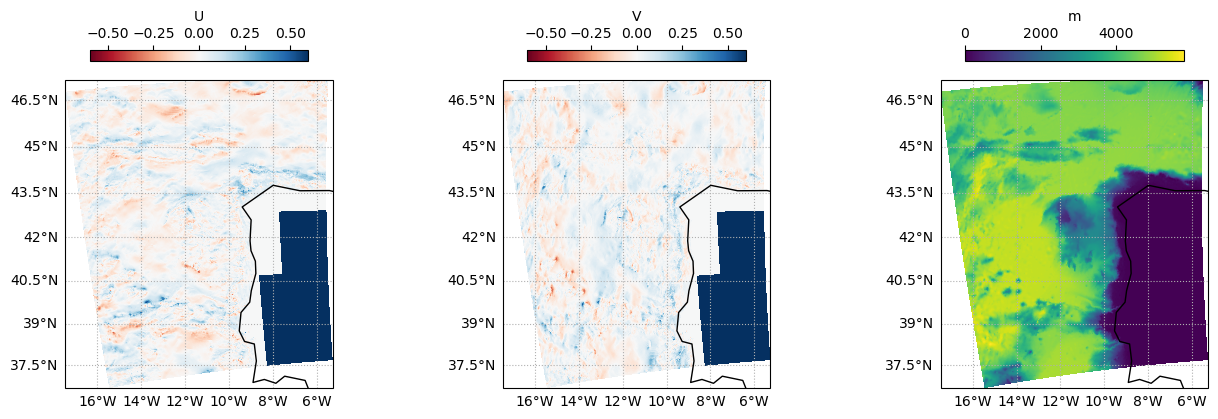

In [10]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='V')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
plt.colorbar(a,location='top',shrink=0.6,label='m')

In [11]:
# Check if we can interpolate ?
print(fieldset.UV[0,1000,40.5,-14],fieldset.bathy[0,1000,40.5,-14])

(-2.9963295298054176e-07, -4.5049453498912875e-07) 3761.804


In [12]:
print(fieldset.gridset.grids[0].depth.min(),fieldset.gridset.grids[0].depth.max())

0.093762346 5826.7


# Virtual Fleet part 

In [13]:
# Set min/max depth for float conf, this is to make sure Parcels doesn't struggle 
min_depth = 2.5 #np.ceil(ds['depth_rho'].max(['sig_rho']).min().values)
max_depth = int(fieldset.gridset.grids[0].depth.max() / 100)*100
print(min_depth,max_depth)
fieldset.add_constant("vf_surface",min_depth)
fieldset.add_constant("vf_bottom", max_depth)

2.5 5800


In [14]:
print(files[0])
print(files[-1])

/home1/datawork/kbalem/gigatl_sample_for_parcels/depth_positive/gigatl1_1h_tides_iberia_daily_2008-12-01.nc
/home1/datawork/kbalem/gigatl_sample_for_parcels/depth_positive/gigatl1_1h_tides_iberia_daily_2008-12-29.nc


In [15]:
# Number of float we want to simulate
#nfloats = 20
# Then we must define numpy array (size nfloats) for lat, lon, depth and time
#lon0, lat0 = -13, 42  # Center of the box
#Lx, Ly = 4, 6.0 # Size of the box
#lon = np.random.uniform(lon0-Lx/2, lon0+Lx/2, size=nfloats)
#lat = np.random.uniform(lat0-Ly/2, lat0+Ly/2, size=nfloats)

fbox = [-15,39,-10,45]
coords=np.array(list(itertools.product(np.arange(fbox[0],fbox[2],.5),np.arange(fbox[1],fbox[3],.5))))
lon = coords[:,0]
lat = coords[:,1]
nfloats=len(lon)
tim = np.array(['2008-12-10T12:00:00.00' for i in range(nfloats)],dtype='datetime64')
depth = np.array([min_depth for i in range(nfloats)])
# Define the deployment plan as a dictionary:
my_plan = {'lat': lat, 
           'lon': lon, 
           'time': tim, 
           'depth':depth}

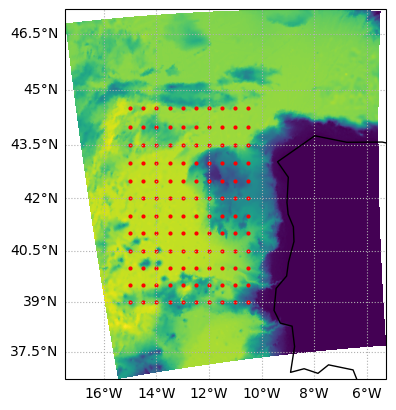

In [16]:
fig=plt.figure()
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 1, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
#b=ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1.plot(my_plan['lon'],my_plan['lat'],'r.',markersize=4,transform=pr1)

In [17]:
cfg = FloatConfiguration('default')
cfg.update('cycle_duration',24*10)
cfg.update('profile_depth',2000)
cfg.update('parking_depth',1000)
cfg

<FloatConfiguration><default>
- cycle_duration (Maximum length of float complete cycle): 240.0 [hours]
- life_expectancy (Maximum number of completed cycle): 200 [cycle]
- parking_depth (Drifting depth): 1000.0 [m]
- profile_depth (Maximum profile depth): 2000.0 [m]
- vertical_speed (Vertical profiling speed): 0.09 [m/s]

In [18]:
VFleet = VirtualFleet(plan=my_plan, fieldset=fieldset, mission=cfg, verbose_events=False)
VFleet

<VirtualFleet>
- 120 floats in the deployment plan
- No simulation performed

In [19]:
VFleet.simulate(
    duration=timedelta(days=29),
    step=timedelta(minutes=5),
    record=timedelta(minutes=30),
    output_folder="/home1/scratch/kbalem/",
)

INFO: Output files are stored in /home1/scratch/kbalem/l2xjv1w6.zarr.
100%|██████████| 2505600.0/2505600.0 [1:17:08<00:00, 541.38it/s]


<VirtualFleet>
- 116 floats in the deployment plan
- Number of simulation(s): 1
- Last simulation meta-data:
	- Duration: 29d 00h 00m 00s
	- Data recording every: 00h 30m
	- Trajectory file: /home1/scratch/kbalem/l2xjv1w6.zarr
	- Execution time: 00d 01h 17m 24s
	- Executed on: r2i1n24

In [20]:
dout=xr.open_zarr('/home1/scratch/kbalem/l2xjv1w6.zarr')
dout.load()

<xarray.Dataset> Size: 9MB
Dimensions:       (trajectory: 120, obs: 1392)
Coordinates:
  * obs           (obs) int32 6kB 0 1 2 3 4 5 ... 1386 1387 1388 1389 1390 1391
  * trajectory    (trajectory) int64 960B 120 121 122 123 ... 236 237 238 239
Data variables:
    cycle_age     (trajectory, obs) float32 668kB 300.0 2.1e+03 ... 7.761e+05
    cycle_number  (trajectory, obs) float64 1MB 1.0 1.0 1.0 1.0 ... 3.0 3.0 3.0
    cycle_phase   (trajectory, obs) float64 1MB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    in_water      (trajectory, obs) float32 668kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat           (trajectory, obs) float64 1MB 39.0 39.0 39.0 ... 43.57 43.57
    lon           (trajectory, obs) float64 1MB -15.0 -15.0 ... -11.71 -11.71
    time          (trajectory, obs) datetime64[ns] 1MB 2008-12-10T12:00:00 .....
    z             (trajectory, obs) float64 1MB 2.5 164.5 326.5 ... 1e+03 1e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.0.4

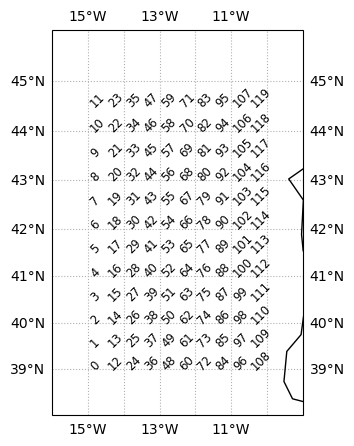

In [56]:
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
fig=plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(projection=pr2)
for i in range(len(dout.trajectory)):
    ax1.text(dout.isel(obs=0)['lon'].values[i],dout.isel(obs=0)['lat'].values[i],
             (dout.isel(obs=0)['trajectory'].values[i] - dout.isel(obs=0)['trajectory'].values[0]).astype('U3'),
             transform=pr1,
             fontsize='small',
             rotation=45.)
extent = [-16,-9,38,46]
ax1.set_extent(extent)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)

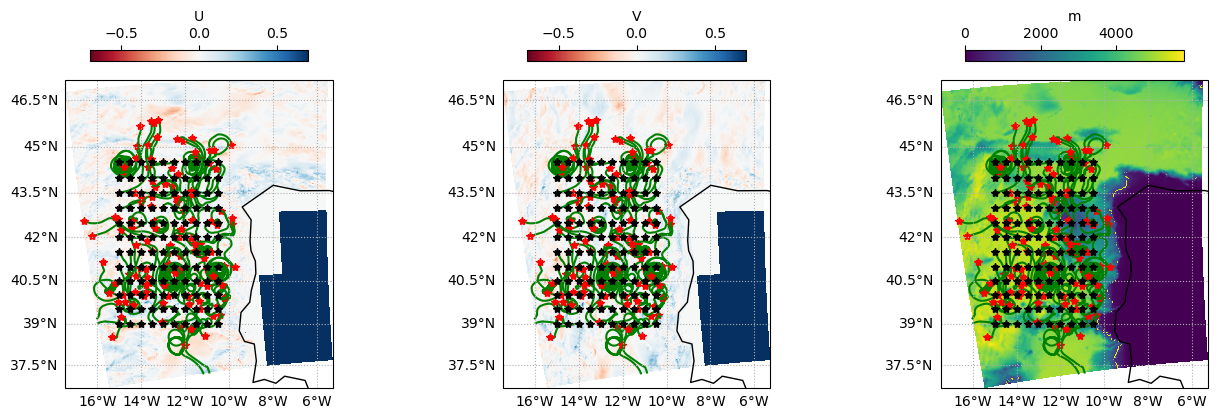

In [21]:
extent = [-15,-12,40.5,45]

fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='U')
#ax1.set_extent(extent)

ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='V')    
#ax1.set_extent(extent)

ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
b=ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='m')
#ax1.set_extent(extent)

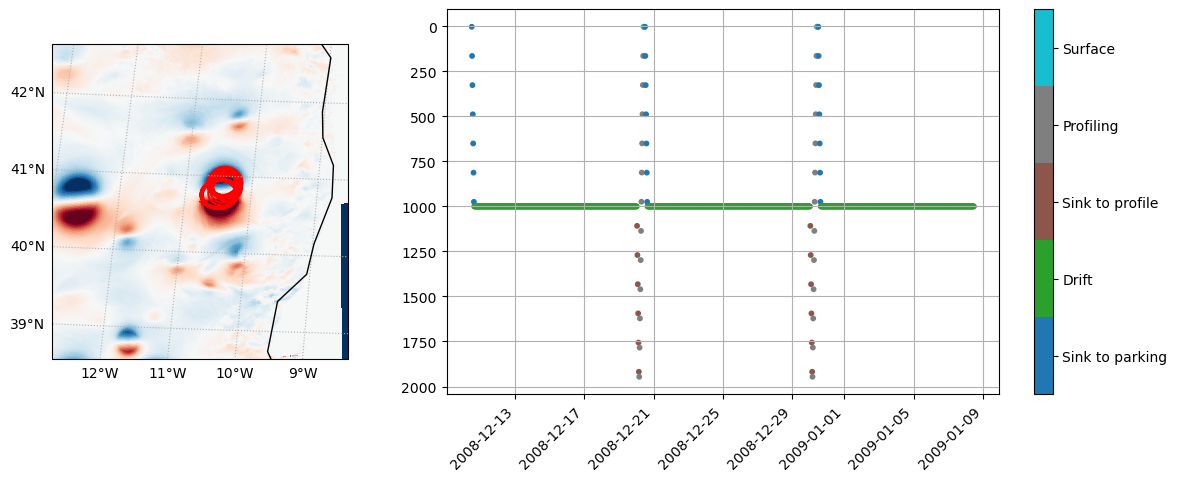

In [59]:
tr=112

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,49,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
#ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'k*',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'r',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1)
extent=[dout['lon'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lon'].isel(trajectory=tr,obs=-1).max().values +2,
        dout['lat'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lat'].isel(trajectory=tr,obs=-1).max().values +2]
ax1.set_extent(extent)

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2011-01-15'),np.datetime64('2011-01-16')])
cb=plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])
cb.set_ticklabels(['Sink to parking','Drift','Sink to profile','Profiling','Surface'])